In [92]:
!pip show networkx

Name: networkx
Version: 3.2.1
Summary: Python package for creating and manipulating graphs and networks
Home-page: 
Author: 
Author-email: Aric Hagberg <hagberg@lanl.gov>
License: 
Location: c:\users\admin\anaconda3\envs\cashatm\lib\site-packages
Requires: 
Required-by: kedro-viz, scikit-image, torch


# Theoretical overview

The proposed Q formula is:
\begin{equation}
Q=\sum_{ij}\left(P_{ji}\phi_{j}-\phi_{i}\phi_{j}\right)\delta_{g_{i}}\delta_{g_{j}}
\end{equation}

The solution is the second eigenvector of $L^{T}$ with $L=\Phi^{1/2}P\Phi^{-1/2}$:
\begin{equation}
L^{T}u=\lambda u
\end{equation}
where $\Phi$ is the diagonal matrix of the stationary distribution of $P$.

The role of the modularity function here is to gradually split into two clusters until Q no longer improves.

The algorithm will be from an initial graph, we will gradually divide it into 2 clusters, the cluster division is carried out in simultaneous directions and if there is a direction where the Q function does not increase, then stop at that direction.

# Approximate the stationary distribution $\Phi$ and the Laplacian matrix $L$

In [93]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import csv
import pickle
import numpy as np
import ast
from numpy.linalg import matrix_power
import itertools
import math
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres
from scipy.linalg import schur, eigvals
import math
import itertools
from numpy import linalg as LA
import seaborn as sns

%matplotlib inline
import random

In [94]:
def compute_stationary_distri(P,number_iteration):
    n = P.shape[0]
    X_init = np.random.rand(n,2)
    Z = np.linalg.qr(X_init)[0]
    #print("before check_non_neg:",Z.shape)
    Z = check_non_neg(Z)
    #print("after check_non_neg:",Z.shape)
    for i in range(number_iteration):
        #print("iteration to compute stationary:",i)
        temp1 = np.dot(P,Z)
        Q = np.linalg.qr(temp1)[0]
        temp_matrix = Q.T.dot(P.dot(Q))
        T, U = schur(temp_matrix)
        T, U = reorder_T(temp_matrix,T,U)
        #print(T)
        Z = np.dot(Q,U)
        #print("before check_non_neg lan 2:",Z.shape)
        Z = check_non_neg(Z)
        #print("after check_non_neg lan 2:",Z.shape)
        temp1 = Z[:,0]
    return temp1/sum(temp1.tolist())


def check_non_neg(Z):
    (r,c) = Z.shape
    #print(r,c)
    first_column = Z[:,0].tolist()
    #print(first_column)
    lst_idx_neg = [1 if i<0 else 0 for i in first_column]
    indices = [i for i, x in enumerate(lst_idx_neg) if x == 1]
    for idx in indices:
        Z[idx,:] = Z[idx,:]*(-1)
    return Z

def reorder_T(temp_matrix,T,U):
    diag_vector = np.diag(T).tolist()
    distance_to_one = [abs(i-1) for i in diag_vector]
    min_distance = min(distance_to_one)
    idx = distance_to_one.index(min_distance)
    Tn, Un, onevari = schur(temp_matrix, output = 'real', sort=lambda x: x == np.diag(T).tolist()[idx])
    return Tn,Un

In [95]:
def Laplacian(P):
    n = P.shape[0]
    temp1 = compute_stationary_distri(P.T,100)
    Pi = temp1/sum(temp1.tolist())
    lst_Pi = Pi.tolist()
    sqrt_Pi_lst = [math.sqrt(i) for i in lst_Pi]
    inverse_sqrt_Pi_lst = [1/math.sqrt(i) for i in lst_Pi]
    sqrt_Pi_matrix = np.diag(sqrt_Pi_lst)
    inverse_sqrt_Pi_matrix = np.diag(inverse_sqrt_Pi_lst)
    #print(sqrt_Pi_matrix.shape,inverse_sqrt_Pi_matrix.shape)
    L_d = sqrt_Pi_matrix.dot(P.dot(inverse_sqrt_Pi_matrix))
    return L_d

# Calculate the 2nd eigenvector of $L^T$
And in case the 2nd eigenvector is complex, find the real eigenvector

In [96]:
def compute_2rd_eigenvector(LT,i):
    w, v = LA.eig(LT)
    n = LT.shape[0]
    temp_Res = v[:, i]
    check_eigenvector = np.iscomplex(temp_Res)
    if all([x == False for x in check_eigenvector]):
        return temp_Res
    else:
        lst_check_eigenvector = [np.iscomplex(v[:, j]) for j in range(2,n)]
        lst_check_complex = [int(all([x == False for x in check])) for check in lst_check_eigenvector]
        if 1 in lst_check_complex:
            index_res = lst_check_complex.index(1)
            print("choosen index eigenvalue is:",index_res+2)
            return v[:,index_res+2]
        else:
            return temp_Res

In [97]:
def compute_2rd_eigenvector3(LT,i):
    w, v = LA.eig(LT)
    n = LT.shape[0]
    lst_check_eigenvalue = [np.iscomplex(w[j]) for j in range(n)]
    lst_check_complex = [int(check) for check in lst_check_eigenvalue]
    if 0 in lst_check_complex:
        lst_index_real_eigenvalue = [t for t, x in enumerate(lst_check_complex) if x == 0]
        lst_real_eigenvalue = [w[j] for j in lst_index_real_eigenvalue]
        lst_sorted_eigenvalue = sorted(set(lst_real_eigenvalue))
        l = len(lst_sorted_eigenvalue)
        if l > 2:
            index_res = w.tolist().index(lst_sorted_eigenvalue[-2])
            print('eigenvalue:',lst_sorted_eigenvalue[-2])
            print("choosen index eigenvalue is:",index_res)
            return v[:,index_res]
        else:
            print("Eigenvalue:\n",w)
            return v[:,i]
    else:
        return v[:,i]

In [98]:
def compute_2rd_eigenvector2(LT,i):
    w, v = LA.eig(LT)
    n = LT.shape[0]
    temp_Res = v[:, i]
    check_eigenvector = np.iscomplex(temp_Res)
    if all([x == False for x in check_eigenvector]):
        return temp_Res
    else:
        lst_check_eigenvalue = [np.iscomplex(w[j]) for j in range(2,n)]
        lst_check_complex = [int(check) for check in lst_check_eigenvalue]
        if 0 in lst_check_complex:
            lst_index_real_eigenvalue = [t for t, x in enumerate(lst_check_complex) if x == 0]
            lst_real_eigenvalue = [w[j+2] for j in lst_index_real_eigenvalue]
            index_res = w.tolist().index(max(lst_real_eigenvalue))
            print('eigenvalue:',w[index_res],max(lst_real_eigenvalue))
            print("choosen index eigenvalue is:",index_res)
            return v[:,index_res]
        else:
            return temp_Res

# Calculate proposed Q function

In [99]:
def compute_proposed_modularity(partition,P,pii):
    nodes = P.shape[0]
    delta_matrix = np.identity(nodes)
    for C in partition:
        aa = list(itertools.combinations(C,2))
        for j in aa:
            delta_matrix[j[0],j[1]] = 1
            delta_matrix[j[1],j[0]] = 1
    modularity_matrix = make_proposed_modularity_matrix(P,pii)
    res = modularity_matrix * delta_matrix
    q = np.sum(res)
    return q
def make_proposed_modularity_matrix(P,pii):#ca 2 dau vao deu la np.array
    temp1 = [pii.tolist() for _ in range(pii.shape[0])]
    matrix_temp_2 = np.array(temp1).T
    matrix_temp_1 = np.array(temp1)
    element_1 = pii * matrix_temp_2
    element_2 = (P.T) * matrix_temp_1
    return element_2 - element_1

In [100]:
def cluster_eigenvector(dct_map, eig_vector):
    lst_sign = np.sign(eig_vector).tolist()
    comm1_idx = [i for i, x in enumerate(lst_sign) if x == 1]
    comm2_idx = [i for i, x in enumerate(lst_sign) if x == -1]
    if len(comm1_idx) + len(comm2_idx) != len(lst_sign):
        print("co van de khi su dung vtr")
    comm2 = [dct_map[i] for i in comm2_idx]
    comm1 = [dct_map[i] for i in comm1_idx]
    return [comm1,comm2]

# Draw the graph

In [101]:
def graph_plot(G, bp,label):
    figure(figsize=(12, 12), dpi=80)
    pos = nx.spring_layout(G)
    nber_nodes =len(G.nodes) ;nber_edges = len(G.edges)
    cmap = plt.get_cmap('Set1')
    colors = cmap(np.linspace(0, 1, len(bp)))
    #print(colors)
    lst_edge = G.edges
    for i, C in enumerate(bp):
        nx.draw_networkx_nodes(G, pos, nodelist=C,node_color=colors[i],node_size=150)
        SG = nx.subgraph(G, C)
        nx.draw_networkx_edges(G, pos, edgelist=SG.edges, width=0.2, alpha=0.5,edge_color = [colors[i] for t in range(len(SG.edges))])
        lst_edge = lst_edge - SG.edges #print(len(G.edges))
    nx.draw_networkx_edges(G, pos, edgelist=lst_edge, width=0.3, alpha=0.5,arrowsize = 4)
    #nx.draw_networkx_labels(G, pos)
    plt.axis('off')
    plt.savefig(str(nber_nodes)+'nodes_'+str(nber_edges)+'edges_'+str(label)+'.png')
    plt.show()

## Create random partition graph

In [102]:
def generate_community_list(N, C):
	return list(np.random.multinomial(N, [1/C]*C, size=1)[0])
def generate_rand_graph(num_of_vertices, vl):
    num_of_communities = math.ceil(num_of_vertices**vl)
    while True:
        G = nx.generators.community.random_partition_graph(
            generate_community_list(num_of_vertices,num_of_communities)
            , 0.5,0.005, directed = True)
        #print("here")
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    #print("xong viec random graph")
    return G
def generate_rand_graph_gaussian(N, mean, sh, p_in, p_out):
    data_test_record.append('Gaussian random partition generator')
    lst_param = [N, mean, sh, p_in, p_out]
    str1 = '-'.join(str(e) for e in lst_param)
    data_test_record.append(str1)
    while True:
        G = nx.generators.community.gaussian_random_partition_graph(N,mean,sh, p_in,p_out, directed = True)
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    return G
def generate_rand_graph_partition_l(number_comm, size_each_comm, p_in, p_out):
    data_test_record.append('Planted l-partition model')
    lst_param = [number_comm, size_each_comm, p_in, p_out]
    str1 = '-'.join(str(e) for e in lst_param)
    data_test_record.append(str1)
    while True:
        G = nx.generators.community.planted_partition_graph(number_comm, size_each_comm
                                                                   , p_in, p_out, directed = True)
        if nx.is_strongly_connected(G):
            break

    N = G.number_of_nodes()

    for x in range(N):
        G.add_edge(x, x)
    return G

Hàm đảm bảo đồ thị là liên thông mạnh và có period = 1

In [103]:
def checking_graph(G1):
    if nx.is_strongly_connected(G1):
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()[0]
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes")
        return P_matrix, G1
    else:
        print("graph is not strongly connected\n------------------")
        '''
        G1 = make_strongly_connected(G1)
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()[0]
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes
        ")
        '''
        return 0

In [104]:
def make_strongly_connected(g):
    lst_components = [list(c) for c in sorted(nx.strongly_connected_components(g), key=len, reverse=True)]
    lst_len_components = [len(i) for i in lst_components]
    for i in range(1,len(lst_components)):
        node_1 = random.choice(lst_components[0])
        node_2 = random.choice(lst_components[0])
        g.add_edge(node_1,lst_components[i][0])
        g.add_edge(lst_components[i][0],node_2)
    return g

# Definition function tách một đồ thị thành 2 + so sánh modularity

In [105]:
def check_condition_modularity_inscrease(C,C1,C2,partition_online):
    newest = len(partition_online) - 1
    oled_value_Q = compute_proposed_modularity(partition_online[newest],P_final,pii_final)
    lst_tempp = partition_online[newest].copy()
    lst_tempp.remove(C)
    lst_tempp.append(C1)
    lst_tempp.append(C2)
    new_value_Q = compute_proposed_modularity(lst_tempp,P_final,pii_final)
    if new_value_Q > oled_value_Q:
        return True
    else:
        return False

In [106]:
def update_partition_online(C,C1,C2,partition_online):
    newest = len(partition_online) - 1
    lst_tempp = partition_online[newest].copy()
    lst_tempp.remove(C)
    partition_online[newest + 1] = lst_tempp
    partition_online[newest+1].append(C1)
    partition_online[newest+1].append(C2)

In [107]:
def divide_edit(C, vari,g):
    if vari and len(C)>1:
        sub_graph = nx.subgraph(g, C)
        dct_mapping = {i:list(sub_graph.nodes())[i] for i in range(len(list(sub_graph.nodes())))}
        dct_mapping_inv = {list(sub_graph.nodes())[i]:i for i in range(len(list(sub_graph.nodes())))}
        sub_graph = nx.relabel_nodes(sub_graph, dct_mapping_inv)
        #print("dct_mapping and its inverse",dct_mapping,'\n',dct_mapping_inv)
        print("-----------\nThe community are considering: ",C)
        a = checking_graph(sub_graph)
        if a==0:
            partition_overall.append(C)
            return
        P_temp, temp_g = checking_graph(sub_graph)
        P_temp = np.array(P_temp)
        pii = np.array(compute_stationary_distri(P_temp,100))
        L = Laplacian(P_temp)
        LT = L.T
        eigenvector = compute_2rd_eigenvector3(LT,1)
        check_eigenvector = np.iscomplex(eigenvector)
        if all([x == False for x in check_eigenvector]):
            [C1, C2] = cluster_eigenvector(dct_mapping, eigenvector)
            if len(C1)*len(C2) == 0:
                print(C1,C2)
                print("Stop this division - there is not any division")
                lst_LT_error.append(LT)
                print(LT)
                partition_overall.append(C)
                return
            print("Seperate: ",C,"->: ",C1," + ",C2)
            if check_condition_modularity_inscrease(C,C1,C2,partition_online):
                update_partition_online(C,C1,C2,partition_online)
                divide_edit(C1,True,g)
                divide_edit(C2,True,g)
            else:
                print(C1,C2)
                print("Stop this division - the modularity can not improved")
                partition_overall.append(C)
                return
        else:
            print(C)
            print("Stop this division - there is not exist positive real eigenvalue")
            lst_LT_error.append(LT)
            print(LT)
            divide_edit(C,False,g)
    else:
        partition_overall.append(C)
        return

In [108]:
def checking_graph2(G1):
    if nx.is_strongly_connected(G1):
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        # print(Adj_matrix_np)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
        # print(Dout_vector)
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes")
        return P_matrix, G1
    else:
        print("graph is not strongly connected\n------------------")
        G1 = make_strongly_connected(G1)
        node_1 = list(G1.nodes())[0]
        G1.add_edge(node_1, node_1)
        Adj_matrix_np = nx.to_numpy_array(G1)
        Dout_vector = np.sum(Adj_matrix_np,axis=1).reshape(Adj_matrix_np.shape[0]).tolist()
        Dout_matrix = np.diag(Dout_vector)
        Dout_inverse_matrix = np.diag([1/i for i in Dout_vector])
        P_matrix = np.dot(Dout_inverse_matrix,Adj_matrix_np)
        #print("checking xong nhes")
        return P_matrix, G1

In [109]:
def divide_edit2(C, vari,g):
    if vari and len(C)>1:
        sub_graph = nx.subgraph(g, C)
        dct_mapping = {i:list(sub_graph.nodes())[i] for i in range(len(list(sub_graph.nodes())))}
        dct_mapping_inv = {list(sub_graph.nodes())[i]:i for i in range(len(list(sub_graph.nodes())))}
        sub_graph = nx.relabel_nodes(sub_graph, dct_mapping_inv)
        #print("dct_mapping and its inverse",dct_mapping,'\n',dct_mapping_inv)
        print("-----------\nThe community are considering: ",C)
        P_temp, temp_g = checking_graph2(sub_graph)
        P_temp = np.array(P_temp)
        pii = np.array(compute_stationary_distri(P_temp,100))
        L = Laplacian(P_temp)
        LT = L.T
        eigenvector = compute_2rd_eigenvector3(LT,1)
        check_eigenvector = np.iscomplex(eigenvector)
        if all([x == False for x in check_eigenvector]):
            [C1, C2] = cluster_eigenvector(dct_mapping, eigenvector)
            if len(C1)*len(C2) == 0:
                print(C1,C2)
                print("Stop this division - there is not any division")
                partition_overall.append(C)
                return
            print("Seperate: ",C,"->: ",C1," + ",C2)
            if check_condition_modularity_inscrease(C,C1,C2,partition_online):
                update_partition_online(C,C1,C2,partition_online)
                divide_edit2(C1,True,g)
                divide_edit2(C2,True,g)
            else:
                print(C1,C2)
                print("Stop this division - the modularity can not improved")
                partition_overall.append(C)
                return
        else:
            #print(C)
            print("Stop this division - there is not exist positive real eigenvalue")
            print("Eigenvector:\n",eigenvector)
            divide_edit2(C,False,g)
    else:
        partition_overall.append(C)
        return



# Create random graph

In [ ]:
data_test_record = []
g = generate_rand_graph_gaussian(80,20,2.5,0.5,0.01)
# g = generate_rand_graph_partition_l(6,25,0.7,0.01)

'''
For the case you want to save graph and re-load that graph later, using the functions save_graph and load_graph below
'''

'\nFor the case you want to save graph and re-load that graph later, using the functions save_graph and load_graph below\n'

# Save graph and load graph

In [111]:
def save_graph(g_copy, link_folder):
  g = g_copy.copy()
  lst_order_nodes_ori = list(g.nodes())
  dct_order_nodes = {i:lst_order_nodes_ori[i] for i in range(len(lst_order_nodes_ori))}
  def compute_silhouette2(g,bp):
      nber_community = len(bp)
      dct_label = {str(c):bp.index(c) for c in bp}
      dct = {}
      for j in range(nber_community):
          dct_temp = {i:dct_label[str(bp[j])] for i in bp[j]}
          dct.update(dct_temp)
      return dct
  dct_node_partition = compute_silhouette2(g,g.graph['partition'])
  nx.write_edgelist(g,link_folder + str(g.number_of_nodes())+'_'+str(g.number_of_edges())+'_directed_for_compare.txt')
  # Save file pickle dictionary kết quả phân cụm
  import collections
  od = collections.OrderedDict(sorted(dct_node_partition.items()))
  dct_node_partition = dict(od)
  with open(link_folder + str(g.number_of_nodes())+'_'+str(g.number_of_edges())+'_Results_cluster_forcompare.pickle', 'wb') as handle:
      pickle.dump(dct_node_partition, handle, protocol=pickle.HIGHEST_PROTOCOL)
  # Save thứ tự node bởi kết quả phân cụm kia dường như là idx của list nodes chứ k phải label của node
  lst_order_vertices = list(g.nodes())
  dct_order = {}
  dct_order['order'] = lst_order_vertices
  with open(link_folder + str(g.number_of_nodes())+'_'+str(g.number_of_edges())+'_order_nodes_forcompare.pickle', 'wb') as handle:
      pickle.dump(dct_order, handle, protocol=pickle.HIGHEST_PROTOCOL)
  with open(link_folder + str(g.number_of_nodes())+'_'+str(g.number_of_edges())+'_directed_for_compare.txt', 'r') as infile:
      lines = infile.readlines()

  # Process each line to remove the "{}" characters
  processed_lines = []
  for line in lines:
      # Split the line by space, take only the first two elements
      v1_v2 = line.split()[:2]
      processed_line = ' '.join(v1_v2)
      processed_lines.append(processed_line)

  # Write the processed lines to the output file
  with open(link_folder + str(g.number_of_nodes())+'_'+str(g.number_of_edges())+'_directed_for_compare.txt', 'w') as outfile:
      for line in processed_lines:
          outfile.write(line + '\n')

In [112]:
link_graph_saved = '../graph_saved/'
save_graph(g, link_folder = link_graph_saved)

In [113]:
import os
os.listdir('../graph_saved/')

['150_2113_directed_for_compare.txt',
 '150_2113_order_nodes_forcompare.pickle',
 '150_2113_Results_cluster_forcompare.pickle',
 '150_2133_directed_for_compare.txt',
 '150_2133_order_nodes_forcompare.pickle',
 '150_2133_Results_cluster_forcompare.pickle',
 '150_2855_directed_for_compare.txt',
 '150_2855_order_nodes_forcompare.pickle',
 '150_2855_Results_cluster_forcompare.pickle']

In [114]:
def load_graph(link_folder, nber_nodes, nber_edges, type_graph = 'undirected'):
  if type_graph == "undirected":
    g1 = nx.read_adjlist(link_folder + str(nber_nodes) + '_' + str(nber_edges) + '_directed_for_compare.txt', nodetype=int,create_using=nx.Graph)
  else:
    g1 = nx.read_adjlist(link_folder + str(nber_nodes) + '_' + str(nber_edges) + '_directed_for_compare.txt', nodetype=int,create_using=nx.DiGraph)

  # Load order of node from the pickle file
  with open(link_folder + str(nber_nodes) + '_' + str(nber_edges) + '_order_nodes_forcompare.pickle', 'rb') as handle:
      dct_lst_order_nodes =  pickle.load(handle)
  lst_order_nodes = dct_lst_order_nodes['order']

  # Load partition
  with open(link_folder + str(nber_nodes) + '_' + str(nber_edges) + '_Results_cluster_forcompare.pickle', 'rb') as handle:
      dct_C_Q = pickle.load(handle)
  lst_value = list(dct_C_Q.values())
  lst_keys = list(dct_C_Q.keys())
  set_value = set(lst_value)
  lst_set_value = [i for i in range(len(set_value))]
  lst_partition_from_file = [[i for i, x in enumerate(lst_value) if x == j] for j in lst_set_value]

  # Create the new Graph class by importing all information above: graph type, edgelist, label, order of nodes
  if type_graph == "undirected":
    g2=nx.Graph() # note: carully to choose class of graph
  else:
    g2 = nx.DiGraph()
  g2.add_nodes_from(lst_order_nodes)
  g2.add_edges_from(list(g1.edges()))
  g2.graph['partition'] = lst_partition_from_file
  return g2

In [115]:
g_loaded = load_graph(link_folder = link_graph_saved, nber_nodes = 150, nber_edges = 2113, type_graph = 'directed')

# Run algorithm

In [ ]:
C_ori = list(g.nodes())
P_final, g1 = checking_graph2(g)
P_final = np.array(P_final)
pii_final = np.array(compute_stationary_distri(P_final,100))

partition_overall = []
partition_online = {}
partition_online[0] = [C_ori]
divide_edit2(C_ori, True,g)
print(partition_online)
lst_label_partition = g.graph['partition']
# print(compute_proposed_modularity(partition_online[len(partition_online)-1],P_final,pii_final))
print("----------------")
print('Qp of label:',compute_proposed_modularity(partition_overall,P_final,pii_final))
print('Qp of proposed:',compute_proposed_modularity(lst_label_partition,P_final,pii_final))


-----------
The community are considering:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
eigenvalue: (0.9397785445600731+0j)
choosen index eigenvalue is: 1
Seperate:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79] ->:  [32, 33, 34, 24, 25, 26, 27, 28, 29, 30, 31, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]  +  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 35, 36, 37, 38, 39, 40,

In [ ]:
def graph_plot(G, bp,label,colors= ['red','green','blue','orange','gray','violet','pink']):
    figure(figsize=(12, 12), dpi=80)
    pos = nx.spring_layout(G)
    nber_nodes =len(G.nodes) ;nber_edges = len(G.edges)
    cmap = plt.get_cmap('Set1')
    if len(bp) > len(colors):
        colors = cmap(np.linspace(0, 1, len(bp)))
    #print(colors)
    lst_edge = G.edges
    for i, C in enumerate(bp):
        nx.draw_networkx_nodes(G, pos, nodelist=C,node_color=colors[i],node_size=150)
        SG = nx.subgraph(G, C)
        nx.draw_networkx_edges(G, pos, edgelist=SG.edges, width=0.2, alpha=0.5,edge_color = [colors[i] for t in range(len(SG.edges))],arrowsize = 14)
        lst_edge = lst_edge - SG.edges #print(len(G.edges))
    nx.draw_networkx_edges(G, pos, edgelist=lst_edge, width=0.3, alpha=0.5,arrowsize = 14)
    #nx.draw_networkx_labels(G, pos)
    plt.axis('off')
    plt.savefig('../images_results/'+str(nber_nodes)+'nodes_'+str(nber_edges)+'edges_'+str(label)+'.png')
    plt.show()

In [130]:
def compute_modularity_general(bp,G):
    nodes = G.number_of_nodes()
    all_links = G.number_of_edges()
    delta_matrix = np.identity(nodes)
    for C in bp:
        aa = list(itertools.combinations(C,2))
        for j in aa:
            #print("j:",j,"aa",aa)
            delta_matrix[j[0],j[1]] = 1
            delta_matrix[j[1],j[0]] = 1
    modularity_matrix = np.array(nx.directed_modularity_matrix(G))
    res = modularity_matrix * delta_matrix
    q = np.sum(res)/(all_links)
    return q

In [131]:
print("Qd modularity - label:", compute_modularity_general(lst_label_partition,g))
print("Qd modularity - proposed modularity", compute_modularity_general(partition_overall,g))

Qd modularity - label: 0.6613019848771265
Qd modularity - proposed modularity 0.6613019848771265


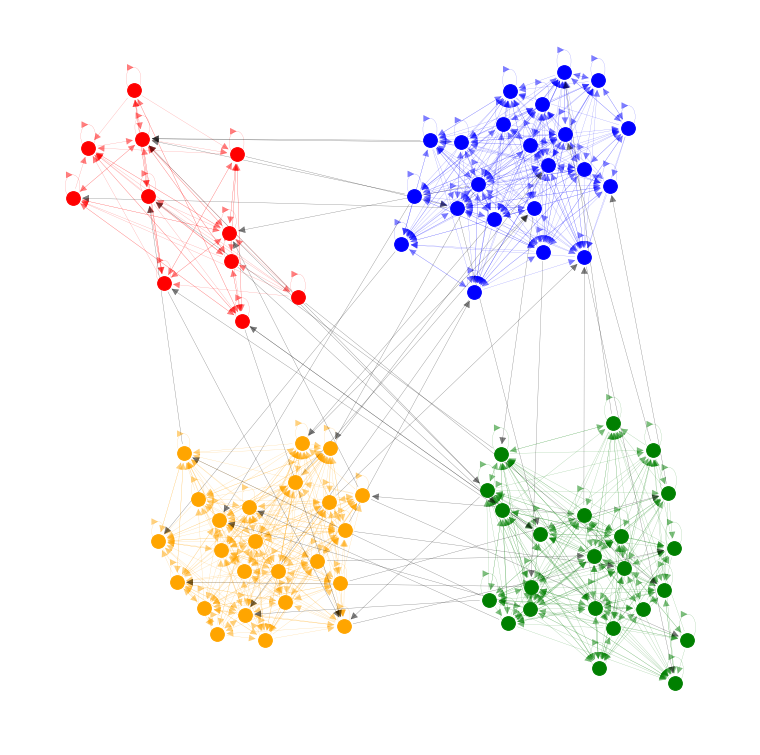

In [ ]:
graph_plot(g, partition_overall,'Q thang 1')

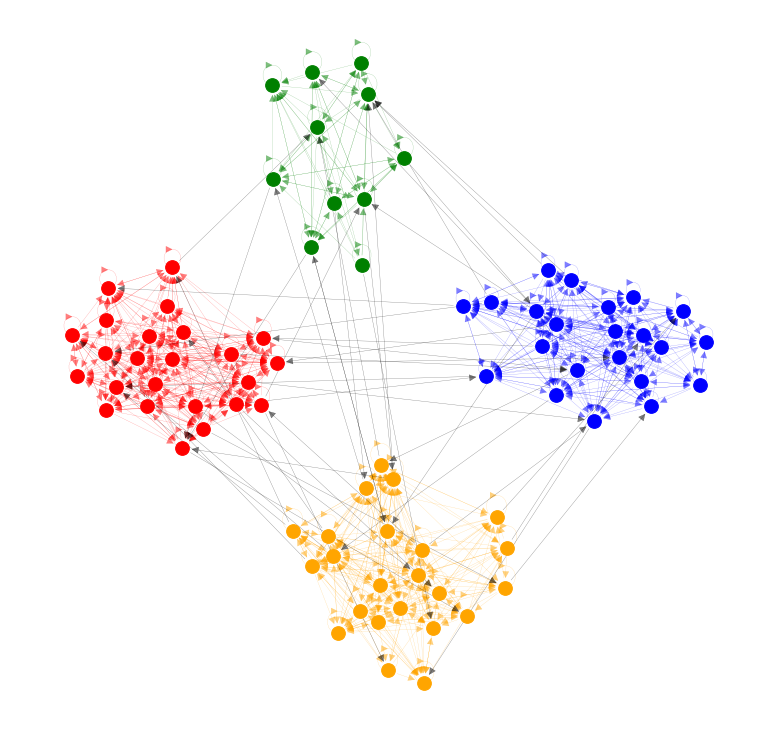

In [ ]:
graph_plot(g, g.graph['partition'],'LABEL')

# Visualization proposed results and label

In [134]:
def rand_index(P1, P2, N):
	v1 = 0
	v2 = 0
	v3 = 0

	for C1 in P1:
		v2 += len(C1)**2
		for C2 in P2:
			v1 += len(set(C1).intersection(C2))**2

	for C2 in P2:
		v3 += len(C2)**2
	return ( \
		(((N**2)*v1) - (v2*v3)) / \
		((((N**2)/2)*(v2+v3)) - (v2*v3))
		)
data_test_record.append(rand_index(partition_overall, lst_label_partition, g.number_of_nodes()))

In [135]:
def make_dct_label(lst_label):
    dct_res = {i:lst_label[i] for i in range(len(lst_label))}
    return dct_res
def Jaccard_score(bp1,bp2):
    nber_real_class = len(bp1)
    nber_clusters = len(bp2)
    dct_class = make_dct_label(bp1)

    dct_cluster = make_dct_label(bp2)

    matrix_Jaccard=np.zeros((nber_real_class,nber_clusters))
    for i in range(nber_real_class):
        for j in range(nber_clusters):
            matrix_Jaccard[i,j] = Jaccard_index_formular(dct_class[i],
            dct_cluster[j])
    return matrix_Jaccard
def Jaccard_index_formular(set1,set2):
    a=set(set1)
    b=set(set2)
    T= len(a & b)
    M= len(a | b)
    return T/M

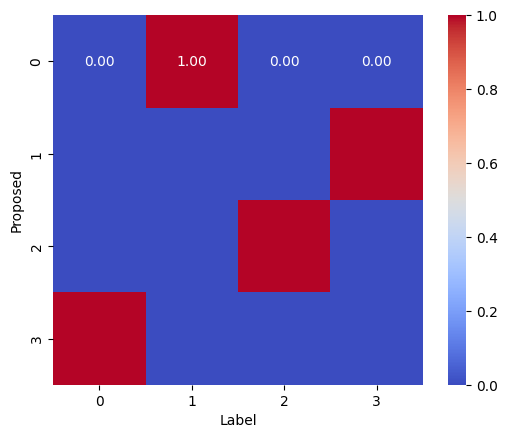

In [138]:
lst_label_partition = [list(i) for i in g.graph['partition']]
bp1 = partition_overall
bp2 = lst_label_partition
matrix_JC=Jaccard_score(bp1,bp2)
lst=[[i,j,matrix_JC[i][j]] for i in range(len(bp1)) for j in range(len(bp2))]
import pandas as pd
df = pd.DataFrame(lst, columns =['Proposed', 'Label','Jaccard_score'])
df2 = df.pivot_table(index='Proposed', columns='Label', values='Jaccard_score', fill_value=0)
matrix_check_to_record = df2.to_numpy()
lst_highest = np.max(matrix_check_to_record,axis = 1)
mean_jaccard = np.mean(lst_highest)
data_test_record.append(mean_jaccard)

ax = sns.heatmap(df2, cmap='coolwarm',
                annot=True,
                fmt=".2f",
                annot_kws={'size':10}, square=True)
ax.figure.savefig('../images_results/Jaccard_matrix_heatmap.png')

In [137]:
df2

Label,0,1,2,3
Proposed,,,,
0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
